In [4]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [5]:
# Step 1: Load the Dataset
def load_images_and_labels(image_folder, label_file, limit=5000):
    images = []
    labels = []
    with open(label_file, 'r') as file:
        for i, line in enumerate(file):
            if i >= limit:
                break
            parts = line.strip().split()
            image_name = parts[0]
            angle = float(parts[1].split(',')[0])  # Extract angle from format 'angle,date time'
            image_path = os.path.join(image_folder, image_name)
            img = cv2.imread(image_path)
            if img is not None:
                images.append(img)
                labels.append(angle)
            else:
                print(f"Warning: Image {image_path} could not be loaded.")
    return np.array(images), np.array(labels)

# Load images and labels
image_folder = 'F:/data'
label_file = 'F:/data.txt'
images, labels = load_images_and_labels(image_folder, label_file)
print(f"Loaded {len(images)} images and {len(labels)} labels.")

Loaded 5000 images and 5000 labels.


In [6]:
# Step 2: Define preprocessing functions
def preprocess_image(img, target_size=(416, 416)):
    img_resized = cv2.resize(img, target_size)
    img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    img_normalized = img_gray / 255.0
    return img_normalized

In [7]:
# Create a data generator for preprocessing and training
def image_data_generator(images, labels, batch_size=32, target_size=(416, 416)):
    num_samples = len(images)
    while True:
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch_images = images[start:end]
            batch_labels = labels[start:end]
            batch_preprocessed_images = np.array([preprocess_image(img, target_size) for img in batch_images])
            batch_preprocessed_images = np.expand_dims(batch_preprocessed_images, axis=-1)  # Add channel dimension
            batch_labels_one_hot = tf.keras.utils.to_categorical(categorize_labels(batch_labels), num_classes=3)
            yield batch_preprocessed_images, batch_labels_one_hot


In [8]:
# Step 3: Build the Lane Detection Model
def build_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(3, activation='softmax')  # 3 classes: left, right, straight
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [9]:
# Build model
input_shape = (416, 416, 1)
model = build_model(input_shape)
model.summary()

C:\Users\91948\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 414, 414, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 207, 207, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 205, 205, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 102, 102, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 665856)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      85,229,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 85,248,899 (325.20 MB)

 Trainable params: 85,248,899 (325.20 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Step 4: Prepare the Data for Training
def categorize_labels(labels):
    categorized_labels = []
    for angle in labels:
        if angle < -1.0:
            categorized_labels.append(0)  # Left
        elif angle > 1.0:
            categorized_labels.append(2)  # Right
        else:
            categorized_labels.append(1)  # Straight
    return np.array(categorized_labels)


In [11]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)


In [20]:
# Create data generators
batch_size = 32  # Adjust batch size as needed
train_generator = image_data_generator(X_train, y_train, batch_size)
val_generator = image_data_generator(X_val, y_val, batch_size)


In [22]:
# Train the model with data generators
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(X_val) // batch_size
)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 359s 3s/step - accuracy: 0.6964 - loss: 3.5394 - val_accuracy: 0.8659 - val_loss: 0.3770
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 355s 3s/step - accuracy: 0.9285 - loss: 0.2406 - val_accuracy: 0.9380 - val_loss: 0.2424
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 348s 3s/step - accuracy: 0.9579 - loss: 0.1341 - val_accuracy: 0.9432 - val_loss: 0.2714
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 371s 3s/step - accuracy: 0.9729 - loss: 0.0919 - val_accuracy: 0.9411 - val_loss: 0.2897
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 349s 3s/step - accuracy: 0.9803 - loss: 0.0618 - val_accuracy: 0.9101 - val_loss: 0.3131
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 351s 3s/step - accuracy: 0.9843 - loss: 0.0587 - val_accuracy: 0.9308 - val_loss: 0.3176
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 348s 3s/step - accuracy: 0.9869 - loss: 0.0514 - val_accuracy: 0.9277 - val_loss: 0.3896
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 352s 3s/step - accuracy: 0.9904 - loss: 0.0478 - val_accu

In [40]:
# Step 5: Evaluate the Model
val_steps = len(X_val) // batch_size
val_images = []
val_labels_one_hot = []

In [42]:
# Collect validation images and labels
for _ in range(val_steps):
    batch_images, batch_labels = next(val_generator)
    val_images.append(batch_images)
    val_labels_one_hot.append(batch_labels)
val_images = np.concatenate(val_images)
val_labels_one_hot = np.concatenate(val_labels_one_hot)
val_labels = np.argmax(val_labels_one_hot, axis=1)

In [44]:
# Generate predictions
y_pred_prob = model.predict(val_images)
y_pred = np.argmax(y_pred_prob, axis=1)

31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 424ms/step


In [45]:
# Calculate confusion matrix and classification report
cm = confusion_matrix(val_labels, y_pred)
cr = classification_report(val_labels, y_pred, target_names=['Left', 'Straight', 'Right'])


In [48]:
# Print classification report
print("Classification Report:")
print(cr)

Classification Report:
              precision    recall  f1-score   support

        Left       0.96      0.99      0.97       174
    Straight       0.80      0.78      0.79       176
       Right       0.95      0.95      0.95       618

    accuracy                           0.92       968
   macro avg       0.90      0.90      0.90       968
weighted avg       0.92      0.92      0.92       968



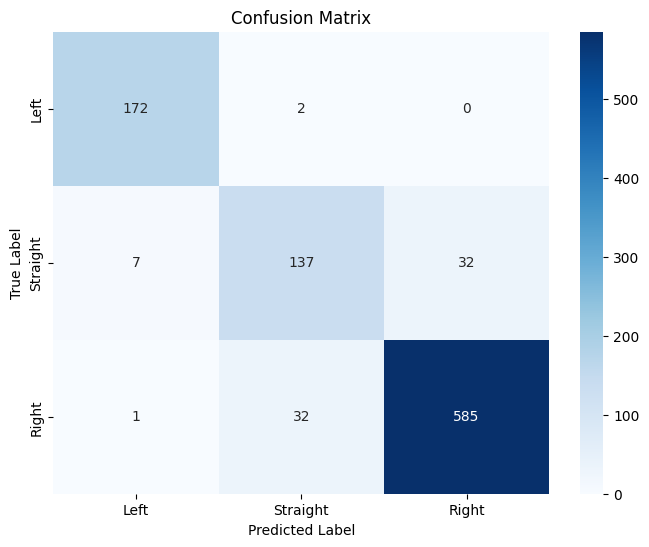

In [50]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Left', 'Straight', 'Right'], yticklabels=['Left', 'Straight', 'Right'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [52]:
# Step 6: Predict Lane Departure
def predict_lane_departure(image, model):
    img_preprocessed = preprocess_image(image)
    img_preprocessed = np.expand_dims(img_preprocessed, axis=(0, -1))  # Add batch and channel dimension
    prediction = model.predict(img_preprocessed)
    return np.argmax(prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


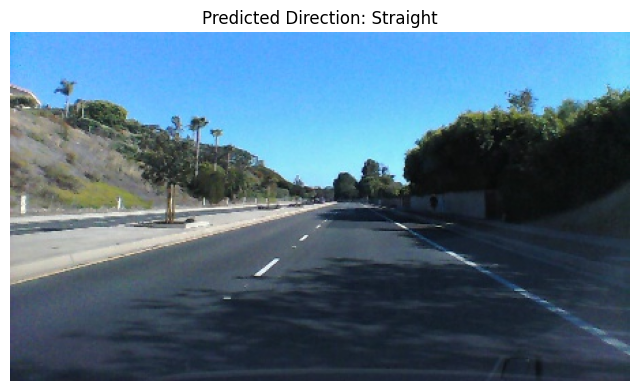

In [68]:
import matplotlib.pyplot as plt

# Example usage
sample_image = images[0]
direction = predict_lane_departure(sample_image, model)
directions = ['Left', 'Straight', 'Right']

# Display the sample image
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
plt.title(f"Predicted Direction: {directions[direction]}")
plt.axis('off')  # Hide the axis
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


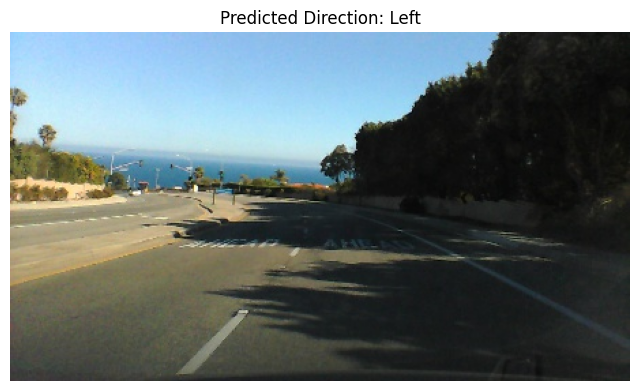

In [70]:
import matplotlib.pyplot as plt

# Example usage
sample_image = images[3000]
direction = predict_lane_departure(sample_image, model)
directions = ['Left', 'Straight', 'Right']

# Display the sample image
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
plt.title(f"Predicted Direction: {directions[direction]}")
plt.axis('off')  # Hide the axis
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


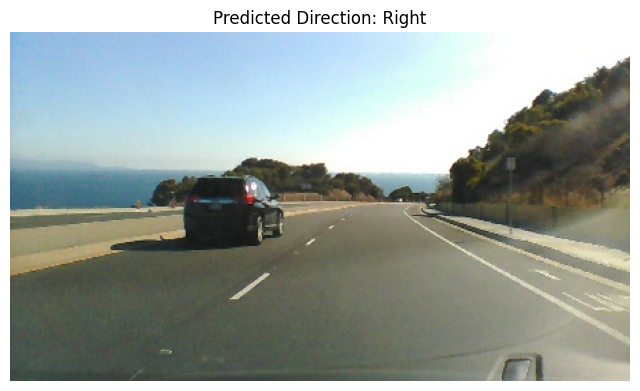

In [72]:
import matplotlib.pyplot as plt

# Example usage
sample_image = images[4000]
direction = predict_lane_departure(sample_image, model)
directions = ['Left', 'Straight', 'Right']

# Display the sample image
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
plt.title(f"Predicted Direction: {directions[direction]}")
plt.axis('off')  # Hide the axis
plt.show()